# Hockey Reference Scraper

This notebook scrapes *forward and defensemen* player data from https://www.hockey-reference.com organized in terms of all players, teams, and season year.

Goalies are not considered

In [14]:
#Import libraries and modules

import requests
import time
import pandas as pd
from bs4 import BeautifulSoup, Comment

import numpy as np
import math

In [2]:
class hr_scraper:
    def __init__(self):
        self.teams={}         # Nested dictionary of {year -> {team -> [players]}}
                              #   Determined by players who played at least one game in the season
        self.player={}        # Dictionary of {name -> databases}
        self.team_url={}      # Nested dictionary of {year -> {team -> url}}
        self.player_url={}    # Dictionary of {name -> url}
    
    def get_teams(self, year):
        start_time=time.time()
        team_page="https://www.hockey-reference.com/leagues/NHL_"+ str(year) + ".html"
        page = requests.get(team_page)
        soup = BeautifulSoup(page.text, 'html.parser')
        self.teams[year]={}
        self.team_url[year]={}
        
        if year!= 2021:
            # Eastern Conference
            EC_table=soup.find_all('div', {"id":"div_standings_EAS"})[0]
            EC_teams=EC_table.find_all('th', {"data-stat":"team_name"})
            for teams in EC_teams[1:]:
                link=teams.find('a').get_attribute_list('href')[0]
                team_name=link[7:10]
                self.team_url[year][team_name]=link
                self.teams[year][team_name]= []

            # Western Conference
            WC_table=soup.find_all('div', {"id":"div_standings_WES"})[0]
            WC_teams=WC_table.find_all('th', {"data-stat":"team_name"})
            for teams in WC_teams[1:]:
                link=teams.find('a').get_attribute_list('href')[0]
                team_name=link[7:10]
                self.team_url[year][team_name]=link
                self.teams[year][team_name]= []
        else: #2021 season had a restructred league; no conferences
            team_table=soup.find_all('div', {"id":"div_standings"})[0].find_all('th', {"data-stat":"team_name"})
            for teams in team_table[1:]:
                link=teams.find('a').get_attribute_list('href')[0]
                team_name=link[7:10]
                self.team_url[year][team_name]=link
                self.teams[year][team_name]= []
    
        return print('Collected teams from the ' + str(year) + ' season with their corresponding urls in ' + str(round(time.time()-start_time,2)) + 's.')
    
    def get_players_on_team(self, year, team):
        start_time=time.time()
        team_page=self.team_url[year][team]
        page = requests.get("https://www.hockey-reference.com"+ team_page)
        soup = BeautifulSoup(page.text, 'html.parser')
        team_players=soup.find_all('table', {"id":"skaters"})[0].find_all("td")
        
        for i,row in enumerate(team_players[:-2]):
            pos_line=team_players[i+2].text #Line labelling position
            html_line=row.find('a')
            if (html_line!=None) and (pos_line !='G'):
                url=html_line.get_attribute_list('href')[0]
                # First player with given name
                if int(url[-6])==1:
                    self.teams[year][team]+= [html_line.text]
                    if (html_line.text not in self.player_url):
                        self.player_url[html_line.text]= url
                # Multiple players with same name
                elif int(url[-6])>1:
                    self.teams[year][team]+= [html_line.text + url[-6]]
                    if (html_line.text + url[-6] not in self.player_url):
                        self.player_url[html_line.text+ url[-6]]= url
        
        return print('Collected player names and urls from ' + team + ' in the ' + str(year) +' season in ' + str(round(time.time()-start_time,2)) + 's.')
    
    def get_player_stats(self, player):
        start_time=time.time()
        player_url=self.player_url[player]
        page = requests.get("https://www.hockey-reference.com"+ player_url)
        soup = BeautifulSoup(page.text, 'html.parser')
        all_tables=pd.read_html(str(soup))
        pos_dict={'D':0, 'C':1, 'LW':1, 'RW':1, 'F':1, 'W':1}
        
        self.player[player]={
                             'Regular season': None,
                             'Regular extra':(None,None,None,None,None,None,None),
                             'Regular possession':(None,None,None,None,None,None,None),
                             'Regular rate':(None,None,None,None,None,None,None),
                             'Regular miscellaneous':None,
                             'Playoff extra':(None,None,None,None,None,None,None),
                             'Playoff possession':(None,None,None,None,None,None,None)
                             }
        
        index_check=0
        if list(all_tables[0].columns)[-1] == ('Unnamed: 29_level_0', 'Awards'):
            index_check=-1

        # The 7 elements of the dictionary are: "All", "Even Strength", 
        # "PP", "SH", "5-on-5", "5-on-5 Close", "5-on-5 Tied"
        
        #Regular season
        self.player[player]['Regular season']=all_tables[1+index_check]

        #NHL Extra Stats Table
        #adv_extra=soup.find_all('div', {'id':'all_adv_extra'})[0]
        self.player[player]['Regular extra']=all_tables[2+index_check:8+index_check]

        #NHL Possession Metrics
        #adv_poss=soup.find_all('div', {'id':'all_adv_poss'})[0]
        self.player[player]['Regular possession']=all_tables[9+index_check:15+index_check]

        #NHL Rate Metrics
        #adv_rate=soup.find_all('div', {'id':'all_adv_rate'})[0]
        self.player[player]['Regular rate']=all_tables[16+index_check:22+index_check]

        #Miscellaneous Stats
        misc=soup.find_all('div', {'id':'all_stats_misc_plus_nhl'})[0].findAll(text=lambda text:isinstance(text, Comment))[0]
        self.player[player]['Regular miscellaneous']=pd.read_html(str(misc))[0]

        #Playoff Extra Stats
        self.player[player]['Playoff extra']=all_tables[23+index_check:29+index_check]

        #Playoff Possession Stats
        self.player[player]['Playoff extra']=all_tables[30+index_check:36+index_check]
        
        #Position: 0=D, 1=F. Assumes that most players with D/F combo mostly play D (e.g. Brent Burns)
        try:
            all_pos=soup.find('p').get_text().replace(':','\xa0').split('\xa0')[1].replace(' ','').replace('\n','').split('/')
            res=[]
            for pos in all_pos:
                res.append(pos_dict[pos])
            self.player[player]['Position']=np.floor(np.mean(res))
        except:
            self.player[player]['Position']=None
        
        print('Tabulated data of player '+player + ' in '+ str(round(time.time()-start_time,2)) + 's.')
        

In [3]:
def add_yahoo_fantasy_weights(obj, player):
    playerData=obj.player[player]['Regular season']
    playerData.insert(0,('Unnamed: -2_level_0', 'Fantasy Points'), playerData['Scoring','G']*6+playerData['Scoring','A']*4+ playerData['Unnamed: 8_level_0','+/-']*2 + (playerData['Goals','PP']+ playerData['Assists','PP'])*2 + playerData['Shots','S']*0.9 + playerData['Unnamed: 25_level_0','BLK'])

# Select Teams

In [4]:
team_dict={'ANA': 0,
 'ARI': 1,
 'BOS': 2,
 'BUF': 3,
 'CAR': 4,
 'CBJ': 5,
 'CGY': 6,
 'CHI': 7,
 'COL': 8,
 'DAL': 9,
 'DET': 10,
 'EDM': 11,
 'FLA': 12,
 'LAK': 13,
 'MIN': 14,
 'MTL': 15,
 'NJD': 16,
 'NSH': 17,
 'NYI': 18,
 'NYR': 19,
 'OTT': 20,
 'PHI': 21,
 'PIT': 22,
 'SEA': 23,
 'SJS': 24,
 'STL': 25,
 'TBL': 26,
 'TOR': 27,
 'VAN': 28,
 'VEG': 29,
 'WPG': 30,
 'WSH': 31,
 'TOT': 32,
 'PHX': 1,
 'ATL': 30}
len(team_dict)

35

In [5]:
fulldata=hr_scraper()

In [6]:
for i in range(2008, 2023):
    fulldata.get_teams(i)

Collected teams from the 2008 season with their corresponding urls in 0.28s.
Collected teams from the 2009 season with their corresponding urls in 0.14s.
Collected teams from the 2010 season with their corresponding urls in 0.12s.
Collected teams from the 2011 season with their corresponding urls in 0.23s.
Collected teams from the 2012 season with their corresponding urls in 0.13s.
Collected teams from the 2013 season with their corresponding urls in 0.11s.
Collected teams from the 2014 season with their corresponding urls in 0.14s.
Collected teams from the 2015 season with their corresponding urls in 0.17s.
Collected teams from the 2016 season with their corresponding urls in 0.12s.
Collected teams from the 2017 season with their corresponding urls in 0.13s.
Collected teams from the 2018 season with their corresponding urls in 0.14s.
Collected teams from the 2019 season with their corresponding urls in 0.12s.
Collected teams from the 2020 season with their corresponding urls in 0.19s.

In [7]:
fulldata.teams[2015]

{'MTL': [],
 'TBL': [],
 'DET': [],
 'OTT': [],
 'BOS': [],
 'FLA': [],
 'TOR': [],
 'BUF': [],
 'NYR': [],
 'NYI': [],
 'WSH': [],
 'PIT': [],
 'CBJ': [],
 'PHI': [],
 'NJD': [],
 'CAR': [],
 'STL': [],
 'NSH': [],
 'CHI': [],
 'MIN': [],
 'WPG': [],
 'DAL': [],
 'COL': [],
 'ANA': [],
 'VAN': [],
 'CGY': [],
 'LAK': [],
 'SJS': [],
 'EDM': [],
 'ARI': []}

# Select Players

In [8]:
for year in list(fulldata.teams.keys()):
    for team in list(fulldata.teams[year].keys()):
        fulldata.get_players_on_team(year, team)

Collected player names and urls from PIT in the 2008 season in 0.23s.
Collected player names and urls from NJD in the 2008 season in 0.2s.
Collected player names and urls from NYR in the 2008 season in 0.2s.
Collected player names and urls from PHI in the 2008 season in 0.17s.
Collected player names and urls from NYI in the 2008 season in 0.18s.
Collected player names and urls from MTL in the 2008 season in 0.21s.
Collected player names and urls from OTT in the 2008 season in 0.18s.
Collected player names and urls from BOS in the 2008 season in 0.17s.
Collected player names and urls from BUF in the 2008 season in 0.2s.
Collected player names and urls from TOR in the 2008 season in 0.18s.
Collected player names and urls from WSH in the 2008 season in 0.17s.
Collected player names and urls from CAR in the 2008 season in 0.3s.
Collected player names and urls from FLA in the 2008 season in 0.2s.
Collected player names and urls from ATL in the 2008 season in 0.19s.
Collected player names an

Collected player names and urls from LAK in the 2011 season in 0.18s.
Collected player names and urls from DAL in the 2011 season in 0.15s.
Collected player names and urls from NYR in the 2012 season in 0.21s.
Collected player names and urls from PIT in the 2012 season in 0.17s.
Collected player names and urls from PHI in the 2012 season in 0.17s.
Collected player names and urls from NJD in the 2012 season in 0.21s.
Collected player names and urls from NYI in the 2012 season in 0.17s.
Collected player names and urls from BOS in the 2012 season in 0.18s.
Collected player names and urls from OTT in the 2012 season in 0.21s.
Collected player names and urls from BUF in the 2012 season in 0.17s.
Collected player names and urls from TOR in the 2012 season in 0.18s.
Collected player names and urls from MTL in the 2012 season in 0.21s.
Collected player names and urls from FLA in the 2012 season in 0.19s.
Collected player names and urls from WSH in the 2012 season in 0.17s.
Collected player nam

Collected player names and urls from SJS in the 2015 season in 0.24s.
Collected player names and urls from EDM in the 2015 season in 0.2s.
Collected player names and urls from ARI in the 2015 season in 0.2s.
Collected player names and urls from FLA in the 2016 season in 0.28s.
Collected player names and urls from TBL in the 2016 season in 0.2s.
Collected player names and urls from DET in the 2016 season in 0.16s.
Collected player names and urls from BOS in the 2016 season in 0.18s.
Collected player names and urls from OTT in the 2016 season in 0.31s.
Collected player names and urls from MTL in the 2016 season in 0.2s.
Collected player names and urls from BUF in the 2016 season in 0.19s.
Collected player names and urls from TOR in the 2016 season in 0.21s.
Collected player names and urls from WSH in the 2016 season in 0.2s.
Collected player names and urls from PIT in the 2016 season in 0.19s.
Collected player names and urls from NYR in the 2016 season in 0.23s.
Collected player names an

Collected player names and urls from SJS in the 2019 season in 0.31s.
Collected player names and urls from VEG in the 2019 season in 0.18s.
Collected player names and urls from ARI in the 2019 season in 0.2s.
Collected player names and urls from VAN in the 2019 season in 0.24s.
Collected player names and urls from ANA in the 2019 season in 0.21s.
Collected player names and urls from EDM in the 2019 season in 0.24s.
Collected player names and urls from LAK in the 2019 season in 0.28s.
Collected player names and urls from BOS in the 2020 season in 0.28s.
Collected player names and urls from TBL in the 2020 season in 0.15s.
Collected player names and urls from TOR in the 2020 season in 0.26s.
Collected player names and urls from FLA in the 2020 season in 0.19s.
Collected player names and urls from MTL in the 2020 season in 0.16s.
Collected player names and urls from BUF in the 2020 season in 0.18s.
Collected player names and urls from OTT in the 2020 season in 0.23s.
Collected player name

In [9]:
fulldata.teams[2012]

{'NYR': ['Marián Gáborík',
  'Brad Richards',
  'Ryan Callahan',
  'Derek Stepan',
  'Michael Del Zotto',
  'Carl Hagelin',
  'Artem Anisimov',
  'Brandon Dubinsky',
  'Ryan McDonagh',
  'Dan Girardi',
  'Brian Boyle',
  'Ruslan Fedotenko',
  'Anton Stralman',
  'Brandon Prust',
  'John Mitchell',
  'Stu Bickel',
  'Jeff Woywitka',
  'Mike Rupp',
  'Steve Eminger',
  'Marc Staal',
  'Erik Christensen',
  'Sean Avery',
  'Mats Zuccarello',
  'Michael Sauer',
  'Wojtek Wolski',
  'Tim Erixon',
  'Andre Deveaux',
  'Brendan Bell2',
  'Kris Newbury',
  'John Scott'],
 'PIT': ['Evgeni Malkin',
  'James Neal',
  'Chris Kunitz',
  'Pascal Dupuis',
  'Jordan Staal',
  'Steve Sullivan',
  'Kris Letang',
  'Matt Cooke',
  'Sidney Crosby',
  'Tyler Kennedy',
  'Paul Martin',
  'Matt Niskanen',
  'Craig Adams',
  'Brooks Orpik',
  'Deryk Engelland',
  'Arron Asham',
  'Richard Park',
  'Joe Vitale',
  'Zbynek Michalek',
  'Dustin Jeffrey',
  'Ben Lovejoy',
  'Simon Despres',
  'Alexandre Picard',


# Get Player stats

In [10]:
len(fulldata.player_url)

2711

In [11]:
for player in list(fulldata.player_url.keys()):
    fulldata.get_player_stats(player)
    add_yahoo_fantasy_weights(fulldata, player)

Tabulated data of player Evgeni Malkin in 1.33s.
Tabulated data of player Sidney Crosby in 1.36s.
Tabulated data of player Sergei Gonchar in 1.06s.
Tabulated data of player Petr Sykora in 0.66s.
Tabulated data of player Ryan Malone in 0.87s.
Tabulated data of player Ryan Whitney in 0.94s.
Tabulated data of player Jordan Staal in 1.29s.
Tabulated data of player Maxime Talbot in 1.26s.
Tabulated data of player Colby Armstrong in 0.74s.
Tabulated data of player Erik Christensen in 1.18s.
Tabulated data of player Tyler Kennedy in 1.05s.
Tabulated data of player Kris Letang in 1.42s.
Tabulated data of player Jarkko Ruutu in 0.78s.
Tabulated data of player Gary Roberts in 0.65s.
Tabulated data of player Georges Laraque in 0.55s.
Tabulated data of player Darryl Sydor in 0.65s.
Tabulated data of player Jeff Taffe in 0.5s.
Tabulated data of player Pascal Dupuis in 1.14s.
Tabulated data of player Brooks Orpik in 1.42s.
Tabulated data of player Marián Hossa in 1.25s.
Tabulated data of player Mark

Tabulated data of player Bryan Smolinski in 0.63s.
Tabulated data of player Maxim Lapierre in 1.49s.
Tabulated data of player Mike Komisarek in 0.99s.
Tabulated data of player Mathieu Dandenault in 0.57s.
Tabulated data of player Tom Kostopoulos in 0.95s.
Tabulated data of player Kyle Chipchura in 0.95s.
Tabulated data of player Patrice Brisebois in 0.49s.
Tabulated data of player Mikhail Grabovski in 0.83s.
Tabulated data of player Josh Gorges in 1.01s.
Tabulated data of player Steve Begin in 0.74s.
Tabulated data of player Francis Bouillon in 0.92s.
Tabulated data of player Ryan O'Byrne in 1.17s.
Tabulated data of player Matt D'Agostini in 1.15s.
Tabulated data of player Corey Locke in 0.44s.
Tabulated data of player Garth Murray in 0.41s.
Tabulated data of player Greg Stewart in 0.57s.
Tabulated data of player Jason Spezza in 1.4s.
Tabulated data of player Daniel Alfredsson in 0.87s.
Tabulated data of player Dany Heatley in 0.94s.
Tabulated data of player Antoine Vermette in 1.47s.


Tabulated data of player Scott Walker in 0.57s.
Tabulated data of player Justin Williams in 1.42s.
Tabulated data of player Jeff Hamilton in 0.56s.
Tabulated data of player Chad Larose in 0.61s.
Tabulated data of player Frantisek Kaberle in 0.46s.
Tabulated data of player Tim Gleason in 1.23s.
Tabulated data of player Andrew Ladd in 1.35s.
Tabulated data of player Trevor Letowski in 0.44s.
Tabulated data of player Bret Hedican in 0.38s.
Tabulated data of player Dennis Seidenberg in 1.4s.
Tabulated data of player Keith Aucoin in 0.87s.
Tabulated data of player Tuomo Ruutu in 1.16s.
Tabulated data of player Niclas Wallin in 0.73s.
Tabulated data of player Glen Wesley in 0.37s.
Tabulated data of player Ryan Bayda in 0.71s.
Tabulated data of player Craig Adams in 1.07s.
Tabulated data of player Tim Conboy in 0.61s.
Tabulated data of player Casey Borer in 0.35s.
Tabulated data of player David Tanabe in 0.35s.
Tabulated data of player Wade Brookbank in 0.34s.
Tabulated data of player Joe Jen

Tabulated data of player Martin Havlát in 0.83s.
Tabulated data of player James Wisniewski in 1.39s.
Tabulated data of player Rene Bourque in 1.06s.
Tabulated data of player Brent Sopel in 1.13s.
Tabulated data of player Cam Barker in 0.78s.
Tabulated data of player Dave Bolland in 0.97s.
Tabulated data of player Yanic Perreault in 0.35s.
Tabulated data of player Adam Burish in 0.75s.
Tabulated data of player Jack Skille in 1.06s.
Tabulated data of player Andrei Zyuzin in 0.35s.
Tabulated data of player Petri Kontiola in 0.33s.
Tabulated data of player Kris Versteeg in 1.46s.
Tabulated data of player Jordan Hendry2 in 0.55s.
Tabulated data of player Jake Dowell in 0.8s.
Tabulated data of player Kevyn Adams in 0.37s.
Tabulated data of player Troy Brouwer in 1.2s.
Tabulated data of player Niklas Hjalmarsson in 1.33s.
Tabulated data of player Adam Berti in 0.36s.
Tabulated data of player Bryan Bickell in 0.95s.
Tabulated data of player Mike Blunden in 0.92s.
Tabulated data of player Colin

Tabulated data of player Alexander Edler in 1.34s.
Tabulated data of player Ryan Shannon in 0.56s.
Tabulated data of player Trevor Linden in 0.5s.
Tabulated data of player Kevin Bieksa in 1.3s.
Tabulated data of player Willie Mitchell in 0.8s.
Tabulated data of player Brad Isbister in 0.38s.
Tabulated data of player Byron Ritchie in 0.57s.
Tabulated data of player Lukas Krajicek in 0.62s.
Tabulated data of player Aaron Miller in 0.36s.
Tabulated data of player Jason Jaffray in 0.41s.
Tabulated data of player Rick Rypien in 0.52s.
Tabulated data of player Luc Bourdon in 0.25s.
Tabulated data of player Mike Brown2 in 1.29s.
Tabulated data of player Jeff Cowan in 0.34s.
Tabulated data of player Mike Weaver in 1.02s.
Tabulated data of player Zack Fitzgerald in 0.31s.
Tabulated data of player Jannik Hansen in 1.16s.
Tabulated data of player Nathan McIver in 0.36s.
Tabulated data of player Ales Hemsky in 1.13s.
Tabulated data of player Shawn Horcoff in 0.75s.
Tabulated data of player Sam Gag

Tabulated data of player Jeff Giuliano in 0.25s.
Tabulated data of player Brian Boyle in 1.65s.
Tabulated data of player Peter Harrold in 0.61s.
Tabulated data of player Teddy Purcell in 0.92s.
Tabulated data of player Brady Murray in 0.24s.
Tabulated data of player John Zeiler in 0.57s.
Tabulated data of player Gabe Gauthier in 0.25s.
Tabulated data of player Jon Klemm in 0.29s.
Tabulated data of player Lauri Tukonen in 0.25s.
Tabulated data of player Anssi Salmela in 0.46s.
Tabulated data of player Petr Vrana in 0.24s.
Tabulated data of player Matt Halischuk in 0.67s.
Tabulated data of player Pierre-Luc Letourneau-Leblond in 0.74s.
Tabulated data of player Patrick Davis in 0.38s.
Tabulated data of player Darroll Powe in 0.69s.
Tabulated data of player Ossi Vaananen in 0.43s.
Tabulated data of player Luca Sbisa in 1.22s.
Tabulated data of player Andreas Nodl in 0.59s.
Tabulated data of player Jon Kalinski in 0.27s.
Tabulated data of player Jamie Fritsch in 0.24s.
Tabulated data of pla

Tabulated data of player Mike Vernace in 0.27s.
Tabulated data of player Jamie McGinn in 1.02s.
Tabulated data of player Brad Staubitz in 0.82s.
Tabulated data of player Claude Lemieux in 0.39s.
Tabulated data of player Riley Armstrong in 0.26s.
Tabulated data of player Derek Joslin in 0.47s.
Tabulated data of player Ryan Vesce in 0.27s.
Tabulated data of player Brett Festerling in 0.45s.
Tabulated data of player Brendan Mikkelson in 0.91s.
Tabulated data of player Brian Salcido in 0.26s.
Tabulated data of player Matt Beleskey in 0.94s.
Tabulated data of player Troy Bodie in 0.46s.
Tabulated data of player James Neal in 1.7s.
Tabulated data of player Fabian Brunnstrom in 0.33s.
Tabulated data of player Landon Wilson2 in 0.35s.
Tabulated data of player Tom Wandell in 0.34s.
Tabulated data of player Ivan Vishnevskiy in 0.28s.
Tabulated data of player Raymond Sawada in 0.29s.
Tabulated data of player Mikkel Boedker in 1.37s.
Tabulated data of player Viktor Tikhonov in 0.34s.
Tabulated dat

Tabulated data of player Joe Vitale in 0.66s.
Tabulated data of player Brian Strait in 0.68s.
Tabulated data of player Derek Stepan in 1.49s.
Tabulated data of player Mats Zuccarello in 1.88s.
Tabulated data of player Ryan McDonagh in 1.48s.
Tabulated data of player Brodie Dupont in 0.39s.
Tabulated data of player Evgeny Grachev in 0.27s.
Tabulated data of player Dale Weise in 1.86s.
Tabulated data of player Mattias Tedenby in 0.37s.
Tabulated data of player Mark Fayne in 0.58s.
Tabulated data of player Jacob Josefson in 0.6s.
Tabulated data of player Matt Taormina in 0.51s.
Tabulated data of player Alexander Vasyunov in 0.26s.
Tabulated data of player Brad Mills in 0.75s.
Tabulated data of player Alexander Urbom in 0.37s.
Tabulated data of player Stephen Gionta in 0.75s.
Tabulated data of player Adam Henrique in 0.97s.
Tabulated data of player Olivier Magnan in 0.27s.
Tabulated data of player Travis Hamonic in 1.24s.
Tabulated data of player Nino Niederreiter in 1.15s.
Tabulated data 

Tabulated data of player Joe Finley in 0.65s.
Tabulated data of player Derek Whitmore in 0.24s.
Tabulated data of player Jake Gardiner in 0.84s.
Tabulated data of player Ryan Hamilton in 0.49s.
Tabulated data of player Carter Ashton in 0.3s.
Tabulated data of player Raphael Diaz in 0.71s.
Tabulated data of player Louis Leblanc in 0.26s.
Tabulated data of player Alexei Emelin in 0.97s.
Tabulated data of player Frédéric St. Denis in 0.29s.
Tabulated data of player Gabriel Dumont in 0.61s.
Tabulated data of player Erik Gudbranson in 1.14s.
Tabulated data of player Mark Cullen2 in 0.25s.
Tabulated data of player Bracken Kearns in 0.47s.
Tabulated data of player Greg Rallo in 0.25s.
Tabulated data of player Colby Robak in 0.77s.
Tabulated data of player Dmitry Orlov in 0.71s.
Tabulated data of player Cody Eakin in 0.98s.
Tabulated data of player Tomas Kundratek in 0.26s.
Tabulated data of player Brett Connolly in 1.35s.
Tabulated data of player Pierre-Cedric Labrie in 0.29s.
Tabulated data 

Tabulated data of player Austin Watson in 0.7s.
Tabulated data of player Filip Forsberg in 1.2s.
Tabulated data of player Joonas Rask in 0.26s.
Tabulated data of player Jordan Schroeder in 0.58s.
Tabulated data of player Frank Corrado in 0.65s.
Tabulated data of player Nicklas Jensen in 0.34s.
Tabulated data of player Steve Pinizzotto in 0.43s.
Tabulated data of player Charlie Coyle in 1.06s.
Tabulated data of player Jonas Brodin in 1.3s.
Tabulated data of player Mikael Granlund in 1.06s.
Tabulated data of player Johan Larsson2 in 0.6s.
Tabulated data of player Nail Yakupov in 0.44s.
Tabulated data of player Justin Schultz in 0.98s.
Tabulated data of player Mark Arcobello in 1.0s.
Tabulated data of player Roman Cervenka in 0.26s.
Tabulated data of player Mark Cundari in 0.26s.
Tabulated data of player Max Reinhart in 0.3s.
Tabulated data of player Ben Hanowski in 0.28s.
Tabulated data of player Ben Street in 0.45s.
Tabulated data of player Carter Bancks in 0.25s.
Tabulated data of play

Tabulated data of player Will Acton in 0.36s.
Tabulated data of player Luke Gazdic in 0.37s.
Tabulated data of player Oscar Klefbom in 0.63s.
Tabulated data of player Taylor Fedun in 1.23s.
Tabulated data of player Tyler Pitlick in 0.7s.
Tabulated data of player Brad Hunt in 0.89s.
Tabulated data of player Jiri Sekac in 0.57s.
Tabulated data of player Jacob de La Rose in 0.69s.
Tabulated data of player Sven Andrighetto in 0.77s.
Tabulated data of player Jonathan Drouin in 1.32s.
Tabulated data of player Nikita Nesterov in 0.59s.
Tabulated data of player Slater Koekkoek in 0.81s.
Tabulated data of player Luke Witkowski in 0.63s.
Tabulated data of player Andrej Nestrasil in 0.37s.
Tabulated data of player Curtis Lazar in 0.93s.
Tabulated data of player Matt Puempel in 0.93s.
Tabulated data of player Shane Prince in 0.55s.
Tabulated data of player David Pastrnak in 0.66s.
Tabulated data of player Seth Griffith in 0.44s.
Tabulated data of player Joseph Morrow2 in 0.59s.
Tabulated data of p

Tabulated data of player Brett Lernout in 0.29s.
Tabulated data of player Jack Eichel in 0.38s.
Tabulated data of player Casey Nelson in 0.32s.
Tabulated data of player Hudson Fasching in 0.41s.
Tabulated data of player Evan Rodrigues in 0.68s.
Tabulated data of player Justin Bailey in 0.46s.
Tabulated data of player Daniel Catenacci in 0.27s.
Tabulated data of player Cole Schneider2 in 0.26s.
Tabulated data of player William Nylander in 0.62s.
Tabulated data of player Zach Hyman in 1.17s.
Tabulated data of player Connor Brown2 in 0.72s.
Tabulated data of player Byron Froese in 0.49s.
Tabulated data of player Nikita Soshnikov in 0.41s.
Tabulated data of player Brendan Leipsic in 0.47s.
Tabulated data of player Tobias Lindberg in 0.36s.
Tabulated data of player Viktor Loov in 0.24s.
Tabulated data of player Frederik Gauthier in 0.63s.
Tabulated data of player Kasperi Kapanen in 1.24s.
Tabulated data of player Rinat Valiev in 0.28s.
Tabulated data of player Chandler Stephenson2 in 0.76s.

Tabulated data of player Zach Werenski in 0.6s.
Tabulated data of player Lukas Sedlak in 0.4s.
Tabulated data of player Markus Nutivaara in 0.65s.
Tabulated data of player Gabriel Carlsson in 0.53s.
Tabulated data of player T.J. Tynan in 0.32s.
Tabulated data of player Jimmy Vesey2 in 0.64s.
Tabulated data of player Pavel Buchnevich in 0.57s.
Tabulated data of player Boo Nieves in 1.21s.
Tabulated data of player Anthony Beauvillier in 0.6s.
Tabulated data of player Joshua Ho-Sang in 0.3s.
Tabulated data of player Mathew Barzal in 0.59s.
Tabulated data of player Connor Jones in 0.26s.
Tabulated data of player Ivan Provorov in 0.55s.
Tabulated data of player Travis Konecny in 0.5s.
Tabulated data of player Roman Lyubimov in 0.25s.
Tabulated data of player Robert Hagg in 0.56s.
Tabulated data of player Samuel Morin in 0.39s.
Tabulated data of player Mike Vecchione in 0.34s.
Tabulated data of player Sebastian Aho in 1.26s.
Tabulated data of player Lucas Wallmark in 0.82s.
Tabulated data of

Tabulated data of player Tucker Poolman in 0.52s.
Tabulated data of player Brendan Lemieux in 1.37s.
Tabulated data of player Sami Niku in 0.42s.
Tabulated data of player Luke Kunin in 0.58s.
Tabulated data of player Nick Seeler in 0.58s.
Tabulated data of player Louis Belpedio in 0.28s.
Tabulated data of player Jordan Greenway2 in 0.53s.
Tabulated data of player Justin Kloos in 0.28s.
Tabulated data of player Carson Soucy in 0.54s.
Tabulated data of player Alexander Kerfoot in 0.62s.
Tabulated data of player Andrei Mironov in 0.25s.
Tabulated data of player Dominic Toninato in 0.54s.
Tabulated data of player Vince Dunn2 in 1.13s.
Tabulated data of player Tage Thompson in 0.4s.
Tabulated data of player Sammy Blais in 0.65s.
Tabulated data of player Mitch Reinke in 0.36s.
Tabulated data of player Dillon Heatherington in 0.43s.
Tabulated data of player Alex DeBrincat in 0.48s.
Tabulated data of player Jan Rutta2 in 0.6s.
Tabulated data of player David Kampf in 0.6s.
Tabulated data of pla

Tabulated data of player Brogan Rafferty in 0.28s.
Tabulated data of player Josh Teves in 0.24s.
Tabulated data of player Kiefer Sherwood in 0.5s.
Tabulated data of player Sam Steel in 0.36s.
Tabulated data of player Max Comtois in 0.35s.
Tabulated data of player Max Jones3 in 0.34s.
Tabulated data of player Josh Mahura in 0.36s.
Tabulated data of player Isac Lundestrom in 1.03s.
Tabulated data of player Caleb Jones in 0.5s.
Tabulated data of player Josh Currie in 0.3s.
Tabulated data of player Joseph Gambardella in 0.25s.
Tabulated data of player Evan Bouchard in 0.33s.
Tabulated data of player Cooper Marody in 0.28s.
Tabulated data of player Patrick Russell in 0.3s.
Tabulated data of player Austin Wagner in 0.38s.
Tabulated data of player Matt Luff in 0.36s.
Tabulated data of player Sean Walker in 0.33s.
Tabulated data of player Carl Grundstrom in 0.34s.
Tabulated data of player Matt Roy4 in 0.34s.
Tabulated data of player Jaret Anderson-Dolan in 0.34s.
Tabulated data of player Blake

Tabulated data of player Drew O'Connor in 0.29s.
Tabulated data of player Philippe Maillet in 0.24s.
Tabulated data of player Connor McMichael in 0.3s.
Tabulated data of player Garrett Pilon in 0.26s.
Tabulated data of player Brian Pinho in 0.36s.
Tabulated data of player Jack Ahcan in 0.29s.
Tabulated data of player Oskar Steen in 0.28s.
Tabulated data of player Alexis Lafreniere in 0.27s.
Tabulated data of player K'Andre Miller in 0.32s.
Tabulated data of player Vitali Kravtsov in 0.25s.
Tabulated data of player Zachary Jones in 0.3s.
Tabulated data of player Morgan Barron in 0.35s.
Tabulated data of player Tarmo Reunanen in 0.3s.
Tabulated data of player Justin Richards in 1.38s.
Tabulated data of player Wade Allison in 0.28s.
Tabulated data of player Jackson Cates in 0.3s.
Tabulated data of player Tanner Laczynski in 0.25s.
Tabulated data of player Maksim Sushko in 0.25s.
Tabulated data of player Cameron York in 0.33s.
Tabulated data of player Yegor Zamula in 0.31s.
Tabulated data 

Tabulated data of player Ben McCartney2 in 0.24s.
Tabulated data of player Jonas Røndbjerg in 0.28s.
Tabulated data of player Jake Leschyshyn in 0.26s.
Tabulated data of player Paul Cotter in 0.26s.
Tabulated data of player Daniil Miromanov in 0.26s.
Tabulated data of player Pavel Dorofeyev in 0.36s.
Tabulated data of player Ben Jones in 0.24s.
Tabulated data of player Mason Mctavish in 1.01s.
Tabulated data of player Benoit-Olivier Groulx in 0.37s.
Tabulated data of player Bryce Kindopp in 0.24s.
Tabulated data of player Jacob Perreault in 0.26s.
Tabulated data of player Brayden Tracey in 0.26s.
Tabulated data of player Sean Durzi in 0.27s.
Tabulated data of player Vladimir Tkachev2 in 0.26s.
Tabulated data of player Samuel Fagemo in 0.24s.
Tabulated data of player Jacob Moverare in 0.25s.
Tabulated data of player Alex Turcotte2 in 0.27s.
Tabulated data of player Walker Duehr in 0.24s.
Tabulated data of player Jonathan Dahlen in 0.26s.
Tabulated data of player Jasper Weatherby in 0.36

In [12]:
import dill
dill_file=open("seasons_08_to_22","wb")
dill_file.write(dill.dumps(fulldata))
dill_file.close()

In [13]:
# Check export worked
dill_file = open("seasons_08_to_22", "rb")
test = dill.load(dill_file)
dill_file.close()

In [14]:
test.teams[2008]

{'PIT': ['Evgeni Malkin',
  'Sidney Crosby',
  'Sergei Gonchar',
  'Petr Sykora',
  'Ryan Malone',
  'Ryan Whitney',
  'Jordan Staal',
  'Maxime Talbot',
  'Colby Armstrong',
  'Erik Christensen',
  'Tyler Kennedy',
  'Kris Letang',
  'Jarkko Ruutu',
  'Gary Roberts',
  'Georges Laraque',
  'Darryl Sydor',
  'Jeff Taffe',
  'Pascal Dupuis',
  'Brooks Orpik',
  'Marián Hossa',
  'Mark Recchi',
  'Adam Hall',
  'Rob Scuderi',
  'Hal Gill',
  'Mark Eaton',
  'Chris Minard',
  'Alex Goligoski',
  'Connor James',
  'Ryan Stone',
  'Kris Beech',
  'Tim Brent',
  'Jonathan Filewich',
  'Alain Nasreddine',
  'Nathan Smith2'],
 'NJD': ['Zach Parise',
  'Patrik Elias',
  'Brian Gionta',
  'John Madden',
  'Jamie Langenbrunner',
  'Dainius Zubrus',
  'Travis Zajac',
  'Paul Martin',
  'Johnny Oduya',
  'Jay Pandolfo',
  'David Clarkson3',
  'Mike Mottau',
  'Sergei Brylin',
  'Karel Rachunek',
  'Arron Asham',
  'Andy Greene',
  'Colin White',
  'Mike Rupp',
  'Sheldon Brookbank',
  'Vitaly Vishn

# Organize data per year

In [3]:
import dill
dill_file = open("seasons_08_to_22", "rb")
fulldata = dill.load(dill_file)
dill_file.close()

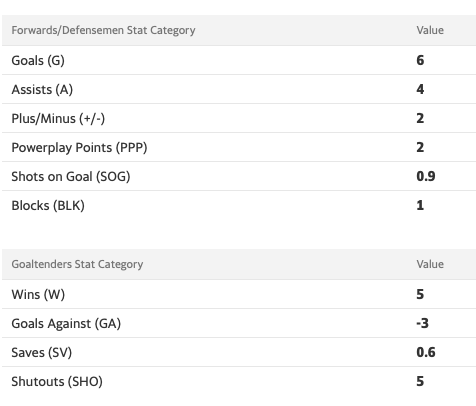

In [4]:
def player_stats_per_year(obj, year, player):
    playerDF=obj.player[player]
    list_sub_tables=["All", "Even Strength", "PP", "SH", "5-on-5", "5-on-5 Close", "5-on-5 Tied"]
    lkeys= list(playerDF.keys())[0:5]
    row=0
    
    # Concatenate all the tables into a single row
    for i, stat_table in enumerate(lkeys):
        playerDF=obj.player[player]
        
        if (stat_table == 'Regular season'):
            playerDF=playerDF[stat_table]
            row= playerDF.loc[playerDF[('Unnamed: 0_level_0','Season')]==year]
            row.insert(0, ('Name','Name'), player)
            row.insert(2, ('Unnamed: -1_level_0', 'Position'), obj.player[player]['Position'])
            row.reset_index(drop=True, inplace=True)
            #print(len(row.columns))
        elif (stat_table == 'Regular extra'):
            for j, sub_table in enumerate(playerDF[stat_table]):
                temp_row=sub_table.loc[sub_table[('Season')]==year].iloc[:,5:]
                colName=[]
                for cname in list(temp_row.columns):
                    colName.append(tuple(('Regular extra: ' + list_sub_tables[j], cname)))

                temp_row.columns = pd.MultiIndex.from_tuples( colName)
                temp_row.reset_index(drop=True, inplace=True)
                #print('Regular extra: '+ str(len(temp_row.columns)))
                row=pd.concat( [row, temp_row ], axis=1)
        elif (stat_table == 'Regular miscellaneous'):
            temp_row=playerDF[stat_table].loc[playerDF[stat_table][('Unnamed: 0_level_0','Season')]==year]
            
            # Players who haven't taken a shootout, and don't have possession quality stats
            if (('Shootouts', 'Att.') not in list(temp_row.columns)) and (('Possession Quality', 'xGF') not in list(temp_row.columns)):
                t1=temp_row.iloc[:, 5:]
                tplus=temp_row.iloc[:, 12:19].copy()
                tplus.columns=pd.MultiIndex.from_tuples( [('Shootouts', 'Att.'), ('Shootouts', 'Made'), ('Shootouts', 'Miss'), ('Shootouts','Pct.'), ('Possession Quality', 'xGF'), ('Possession Quality', 'xGA'), ('Possession Quality', 'E+/-')] ) 
                tplus.loc[:,:]=None
                temp_row=pd.concat([t1,tplus], axis=1)
            # Players who haven't taken a shootout
            elif ('Shootouts', 'Att.') not in list(temp_row.columns):
                t1=temp_row.iloc[:, 5:24]
                tplus=temp_row.iloc[:, 12:16].copy()
                tplus.columns=pd.MultiIndex.from_tuples( [('Shootouts', 'Att.'), ('Shootouts', 'Made'), ('Shootouts', 'Miss'), ('Shootouts','Pct.')] ) 
                tplus.loc[:,:]=None
                t2=temp_row.iloc[:, 24:]
                temp_row=pd.concat([t1,tplus,t2], axis=1)
            # Older players where possession quality metrics didn't exist
            elif ('Possession Quality', 'xGF') not in list(temp_row.columns):
                t1=temp_row.iloc[:, 5:]
                tplus=temp_row.iloc[:, 12:15].copy()
                tplus.columns=pd.MultiIndex.from_tuples( [('Possession Quality', 'xGF'), ('Possession Quality', 'xGA'), ('Possession Quality', 'E+/-')] ) 
                tplus.loc[:,:]=None
                temp_row=pd.concat([t1,tplus], axis=1)
            # Players who have taken a shutout and have possession quality stats
            elif (('Shootouts', 'Att.') in list(temp_row.columns) ) and (('Possession Quality', 'xGF') in list(temp_row.columns)): 
                temp_row=temp_row.iloc[:, 5:]

            temp_row.reset_index(drop=True, inplace=True)
            row= pd.concat( [row, temp_row ], axis=1)
        
        else:
            for j, sub_table in enumerate(playerDF[stat_table]):
                temp_row=sub_table.loc[sub_table[('Unnamed: 0_level_0','Season')]==year].iloc[:, 5:]
                #print(str(stat_table) + ' ' + str(len(temp_row.columns)))
                temp_row.reset_index(drop=True, inplace=True)
                row= pd.concat( [row, temp_row ], axis=1)
                
    # Remove certain columns
    tobe_removed=[('Unnamed: 29_level_0', 'Awards')]
    for i, col_name in tobe_removed:
        row.drop(col_name, axis=1, inplace=True)
    
    return row

def create_data_per_year(obj, year):
    # Get player names
    player_names=[]
    for team in list(obj.teams[int(year)].keys() ):
        player_names+=obj.teams[int(year)][team]
        
    # Get database for players in that year
    final_data=player_stats_per_year(obj, str(year-1)+'-'+f'{year-2000:02d}', player_names[0])
    for player in player_names[1:]:
        print(player)
        data=player_stats_per_year(obj, str(year-1)+'-'+f'{year-2000:02d}', player)
        final_data= final_data.append(data, ignore_index=True )
    
    return final_data

In [5]:
# Column dictionary for all stats available
col_dict={0: ('Name', 'Name'),
 1: ('Unnamed: -2_level_0', 'Fantasy Points'),
 2: ('Unnamed: -1_level_0', 'Position'),
 3: ('Unnamed: 0_level_0', 'Season'),
 4: ('Unnamed: 1_level_0', 'Age'),
 5: ('Unnamed: 2_level_0', 'Tm'),
 6: ('Unnamed: 3_level_0', 'Lg'),
 7: ('Unnamed: 4_level_0', 'GP'),
 8: ('Scoring', 'G'),
 9: ('Scoring', 'A'),
 10: ('Scoring', 'PTS'),
 11: ('Unnamed: 8_level_0', '+/-'),
 12: ('Unnamed: 9_level_0', 'PIM'),
 13: ('Goals', 'EV'),
 14: ('Goals', 'PP'),
 15: ('Goals', 'SH'),
 16: ('Goals', 'GW'),
 17: ('Assists', 'EV'),
 18: ('Assists', 'PP'),
 19: ('Assists', 'SH'),
 20: ('Shots', 'S'),
 21: ('Shots', 'S%'),
 22: ('Shots', 'TSA'),
 23: ('Ice Time', 'TOI'),
 24: ('Ice Time', 'ATOI'),
 25: ('Unnamed: 22_level_0', 'FOW'),
 26: ('Unnamed: 23_level_0', 'FOL'),
 27: ('Unnamed: 24_level_0', 'FO%'),
 28: ('Unnamed: 25_level_0', 'BLK'),
 29: ('Unnamed: 26_level_0', 'HIT'),
 30: ('Unnamed: 27_level_0', 'TK'),
 31: ('Unnamed: 28_level_0', 'GV'),
 32: ('Unnamed: 29_level_0', 'Awards'),
 33: ('Regular extra: All', 'G'),
 34: ('Regular extra: All', 'A'),
 35: ('Regular extra: All', 'PTS'),
 36: ('Regular extra: All', 'S'),
 37: ('Regular extra: All', 'BA'),
 38: ('Regular extra: All', 'MISS'),
 39: ('Regular extra: All', 'TSA'),
 40: ('Regular extra: All', 'SThr%'),
 41: ('Regular extra: All', 'FOW'),
 42: ('Regular extra: All', 'FOL'),
 43: ('Regular extra: All', 'FO%'),
 44: ('Regular extra: All', 'HIT'),
 45: ('Regular extra: All', 'BLK'),
 46: ('Regular extra: All', 'TK'),
 47: ('Regular extra: All', 'GV'),
 48: ('Regular extra: Even Strength', 'G'),
 49: ('Regular extra: Even Strength', 'A'),
 50: ('Regular extra: Even Strength', 'PTS'),
 51: ('Regular extra: Even Strength', 'S'),
 52: ('Regular extra: Even Strength', 'BA'),
 53: ('Regular extra: Even Strength', 'MISS'),
 54: ('Regular extra: Even Strength', 'TSA'),
 55: ('Regular extra: Even Strength', 'SThr%'),
 56: ('Regular extra: Even Strength', 'FOW'),
 57: ('Regular extra: Even Strength', 'FOL'),
 58: ('Regular extra: Even Strength', 'FO%'),
 59: ('Regular extra: Even Strength', 'HIT'),
 60: ('Regular extra: Even Strength', 'BLK'),
 61: ('Regular extra: Even Strength', 'TK'),
 62: ('Regular extra: Even Strength', 'GV'),
 63: ('Regular extra: PP', 'G'),
 64: ('Regular extra: PP', 'A'),
 65: ('Regular extra: PP', 'PTS'),
 66: ('Regular extra: PP', 'S'),
 67: ('Regular extra: PP', 'BA'),
 68: ('Regular extra: PP', 'MISS'),
 69: ('Regular extra: PP', 'TSA'),
 70: ('Regular extra: PP', 'SThr%'),
 71: ('Regular extra: PP', 'FOW'),
 72: ('Regular extra: PP', 'FOL'),
 73: ('Regular extra: PP', 'FO%'),
 74: ('Regular extra: PP', 'HIT'),
 75: ('Regular extra: PP', 'BLK'),
 76: ('Regular extra: PP', 'TK'),
 77: ('Regular extra: PP', 'GV'),
 78: ('Regular extra: SH', 'G'),
 79: ('Regular extra: SH', 'A'),
 80: ('Regular extra: SH', 'PTS'),
 81: ('Regular extra: SH', 'S'),
 82: ('Regular extra: SH', 'BA'),
 83: ('Regular extra: SH', 'MISS'),
 84: ('Regular extra: SH', 'TSA'),
 85: ('Regular extra: SH', 'SThr%'),
 86: ('Regular extra: SH', 'FOW'),
 87: ('Regular extra: SH', 'FOL'),
 88: ('Regular extra: SH', 'FO%'),
 89: ('Regular extra: SH', 'HIT'),
 90: ('Regular extra: SH', 'BLK'),
 91: ('Regular extra: SH', 'TK'),
 92: ('Regular extra: SH', 'GV'),
 93: ('Regular extra: 5-on-5', 'G'),
 94: ('Regular extra: 5-on-5', 'A'),
 95: ('Regular extra: 5-on-5', 'PTS'),
 96: ('Regular extra: 5-on-5', 'S'),
 97: ('Regular extra: 5-on-5', 'BA'),
 98: ('Regular extra: 5-on-5', 'MISS'),
 99: ('Regular extra: 5-on-5', 'TSA'),
 100: ('Regular extra: 5-on-5', 'SThr%'),
 101: ('Regular extra: 5-on-5', 'FOW'),
 102: ('Regular extra: 5-on-5', 'FOL'),
 103: ('Regular extra: 5-on-5', 'FO%'),
 104: ('Regular extra: 5-on-5', 'HIT'),
 105: ('Regular extra: 5-on-5', 'BLK'),
 106: ('Regular extra: 5-on-5', 'TK'),
 107: ('Regular extra: 5-on-5', 'GV'),
 108: ('Regular extra: 5-on-5 Close', 'G'),
 109: ('Regular extra: 5-on-5 Close', 'A'),
 110: ('Regular extra: 5-on-5 Close', 'PTS'),
 111: ('Regular extra: 5-on-5 Close', 'S'),
 112: ('Regular extra: 5-on-5 Close', 'BA'),
 113: ('Regular extra: 5-on-5 Close', 'MISS'),
 114: ('Regular extra: 5-on-5 Close', 'TSA'),
 115: ('Regular extra: 5-on-5 Close', 'SThr%'),
 116: ('Regular extra: 5-on-5 Close', 'FOW'),
 117: ('Regular extra: 5-on-5 Close', 'FOL'),
 118: ('Regular extra: 5-on-5 Close', 'FO%'),
 119: ('Regular extra: 5-on-5 Close', 'HIT'),
 120: ('Regular extra: 5-on-5 Close', 'BLK'),
 121: ('Regular extra: 5-on-5 Close', 'TK'),
 122: ('Regular extra: 5-on-5 Close', 'GV'),
 123: ('Unnamed: 5_level_0', 'TOI'),
 124: ('Corsi (All)', 'CF'),
 125: ('Corsi (All)', 'CA'),
 126: ('Corsi (All)', 'CF%'),
 127: ('Corsi (All)', 'CF% rel'),
 128: ('Fenwick (All)', 'FF'),
 129: ('Fenwick (All)', 'FA'),
 130: ('Fenwick (All)', 'FF%'),
 131: ('Fenwick (All)', 'FF% rel'),
 132: ('PDO (All)', 'oiGF'),
 133: ('PDO (All)', 'oiSH%'),
 134: ('PDO (All)', 'oiGA'),
 135: ('PDO (All)', 'oiSV%'),
 136: ('PDO (All)', 'PDO'),
 137: ('Zone Starts (All)', 'oZS%'),
 138: ('Zone Starts (All)', 'dZS%'),
 139: ('Unnamed: 5_level_0', 'TOI'),
 140: ('Corsi (EV)', 'CF'),
 141: ('Corsi (EV)', 'CA'),
 142: ('Corsi (EV)', 'CF%'),
 143: ('Corsi (EV)', 'CF% rel'),
 144: ('Fenwick (EV)', 'FF'),
 145: ('Fenwick (EV)', 'FA'),
 146: ('Fenwick (EV)', 'FF%'),
 147: ('Fenwick (EV)', 'FF% rel'),
 148: ('PDO (EV)', 'oiGF'),
 149: ('PDO (EV)', 'oiSH%'),
 150: ('PDO (EV)', 'oiGA'),
 151: ('PDO (EV)', 'oiSV%'),
 152: ('PDO (EV)', 'PDO'),
 153: ('Zone Starts (EV)', 'oZS%'),
 154: ('Zone Starts (EV)', 'dZS%'),
 155: ('Unnamed: 5_level_0', 'TOI'),
 156: ('Corsi (PP)', 'CF'),
 157: ('Corsi (PP)', 'CA'),
 158: ('Corsi (PP)', 'CF%'),
 159: ('Corsi (PP)', 'CF% rel'),
 160: ('Fenwick (PP)', 'FF'),
 161: ('Fenwick (PP)', 'FA'),
 162: ('Fenwick (PP)', 'FF%'),
 163: ('Fenwick (PP)', 'FF% rel'),
 164: ('PDO (PP)', 'oiGF'),
 165: ('PDO (PP)', 'oiSH%'),
 166: ('PDO (PP)', 'oiGA'),
 167: ('PDO (PP)', 'oiSV%'),
 168: ('PDO (PP)', 'PDO'),
 169: ('Zone Starts (PP)', 'oZS%'),
 170: ('Zone Starts (PP)', 'dZS%'),
 171: ('Unnamed: 5_level_0', 'TOI'),
 172: ('Corsi (SH)', 'CF'),
 173: ('Corsi (SH)', 'CA'),
 174: ('Corsi (SH)', 'CF%'),
 175: ('Corsi (SH)', 'CF% rel'),
 176: ('Fenwick (SH)', 'FF'),
 177: ('Fenwick (SH)', 'FA'),
 178: ('Fenwick (SH)', 'FF%'),
 179: ('Fenwick (SH)', 'FF% rel'),
 180: ('PDO (SH)', 'oiGF'),
 181: ('PDO (SH)', 'oiSH%'),
 182: ('PDO (SH)', 'oiGA'),
 183: ('PDO (SH)', 'oiSV%'),
 184: ('PDO (SH)', 'PDO'),
 185: ('Zone Starts (SH)', 'oZS%'),
 186: ('Zone Starts (SH)', 'dZS%'),
 187: ('Unnamed: 5_level_0', 'TOI'),
 188: ('Corsi (5v5)', 'CF'),
 189: ('Corsi (5v5)', 'CA'),
 190: ('Corsi (5v5)', 'CF%'),
 191: ('Corsi (5v5)', 'CF% rel'),
 192: ('Fenwick (5v5)', 'FF'),
 193: ('Fenwick (5v5)', 'FA'),
 194: ('Fenwick (5v5)', 'FF%'),
 195: ('Fenwick (5v5)', 'FF% rel'),
 196: ('PDO (5v5)', 'oiGF'),
 197: ('PDO (5v5)', 'oiSH%'),
 198: ('PDO (5v5)', 'oiGA'),
 199: ('PDO (5v5)', 'oiSV%'),
 200: ('PDO (5v5)', 'PDO'),
 201: ('Zone Starts (5v5)', 'oZS%'),
 202: ('Zone Starts (5v5)', 'dZS%'),
 203: ('Unnamed: 5_level_0', 'TOI'),
 204: ('Corsi (5v5 close)', 'CF'),
 205: ('Corsi (5v5 close)', 'CA'),
 206: ('Corsi (5v5 close)', 'CF%'),
 207: ('Corsi (5v5 close)', 'CF% rel'),
 208: ('Fenwick (5v5 close)', 'FF'),
 209: ('Fenwick (5v5 close)', 'FA'),
 210: ('Fenwick (5v5 close)', 'FF%'),
 211: ('Fenwick (5v5 close)', 'FF% rel'),
 212: ('PDO (5v5 close)', 'oiGF'),
 213: ('PDO (5v5 close)', 'oiSH%'),
 214: ('PDO (5v5 close)', 'oiGA'),
 215: ('PDO (5v5 close)', 'oiSV%'),
 216: ('PDO (5v5 close)', 'PDO'),
 217: ('Zone Starts (5v5 close)', 'oZS%'),
 218: ('Zone Starts (5v5 close)', 'dZS%'),
 219: ('Unnamed: 5_level_0', 'G/60'),
 220: ('Unnamed: 6_level_0', 'A/60'),
 221: ('Unnamed: 7_level_0', 'A1/60'),
 222: ('Unnamed: 8_level_0', 'A2/60'),
 223: ('Unnamed: 9_level_0', 'PTS/60'),
 224: ('Unnamed: 10_level_0', 'S/60'),
 225: ('Unnamed: 11_level_0', 'oiGF/60'),
 226: ('Unnamed: 12_level_0', 'oiGA/60'),
 227: ('Corsi (All)', 'CF/60'),
 228: ('Corsi (All)', 'CA/60'),
 229: ('Corsi (All)', 'C/60'),
 230: ('Fenwick (All)', 'FF/60'),
 231: ('Fenwick (All)', 'FA/60'),
 232: ('Fenwick (All)', 'F/60'),
 233: ('Unnamed: 5_level_0', 'G/60'),
 234: ('Unnamed: 6_level_0', 'A/60'),
 235: ('Unnamed: 7_level_0', 'A1/60'),
 236: ('Unnamed: 8_level_0', 'A2/60'),
 237: ('Unnamed: 9_level_0', 'PTS/60'),
 238: ('Unnamed: 10_level_0', 'S/60'),
 239: ('Unnamed: 11_level_0', 'oiGF/60'),
 240: ('Unnamed: 12_level_0', 'oiGA/60'),
 241: ('Corsi (EV)', 'CF/60'),
 242: ('Corsi (EV)', 'CA/60'),
 243: ('Corsi (EV)', 'C/60'),
 244: ('Fenwick (EV)', 'FF/60'),
 245: ('Fenwick (EV)', 'FA/60'),
 246: ('Fenwick (EV)', 'F/60'),
 247: ('Unnamed: 5_level_0', 'G/60'),
 248: ('Unnamed: 6_level_0', 'A/60'),
 249: ('Unnamed: 7_level_0', 'A1/60'),
 250: ('Unnamed: 8_level_0', 'A2/60'),
 251: ('Unnamed: 9_level_0', 'PTS/60'),
 252: ('Unnamed: 10_level_0', 'S/60'),
 253: ('Unnamed: 11_level_0', 'oiGF/60'),
 254: ('Unnamed: 12_level_0', 'oiGA/60'),
 255: ('Corsi (PP)', 'CF/60'),
 256: ('Corsi (PP)', 'CA/60'),
 257: ('Corsi (PP)', 'C/60'),
 258: ('Fenwick (PP)', 'FF/60'),
 259: ('Fenwick (PP)', 'FA/60'),
 260: ('Fenwick (PP)', 'F/60'),
 261: ('Unnamed: 5_level_0', 'G/60'),
 262: ('Unnamed: 6_level_0', 'A/60'),
 263: ('Unnamed: 7_level_0', 'A1/60'),
 264: ('Unnamed: 8_level_0', 'A2/60'),
 265: ('Unnamed: 9_level_0', 'PTS/60'),
 266: ('Unnamed: 10_level_0', 'S/60'),
 267: ('Unnamed: 11_level_0', 'oiGF/60'),
 268: ('Unnamed: 12_level_0', 'oiGA/60'),
 269: ('Corsi (SH)', 'CF/60'),
 270: ('Corsi (SH)', 'CA/60'),
 271: ('Corsi (SH)', 'C/60'),
 272: ('Fenwick (SH)', 'FF/60'),
 273: ('Fenwick (SH)', 'FA/60'),
 274: ('Fenwick (SH)', 'F/60'),
 275: ('Unnamed: 5_level_0', 'G/60'),
 276: ('Unnamed: 6_level_0', 'A/60'),
 277: ('Unnamed: 7_level_0', 'A1/60'),
 278: ('Unnamed: 8_level_0', 'A2/60'),
 279: ('Unnamed: 9_level_0', 'PTS/60'),
 280: ('Unnamed: 10_level_0', 'S/60'),
 281: ('Unnamed: 11_level_0', 'oiGF/60'),
 282: ('Unnamed: 12_level_0', 'oiGA/60'),
 283: ('Corsi (5v5)', 'CF/60'),
 284: ('Corsi (5v5)', 'CA/60'),
 285: ('Corsi (5v5)', 'C/60'),
 286: ('Fenwick (5v5)', 'FF/60'),
 287: ('Fenwick (5v5)', 'FA/60'),
 288: ('Fenwick (5v5)', 'F/60'),
 289: ('Unnamed: 5_level_0', 'G/60'),
 290: ('Unnamed: 6_level_0', 'A/60'),
 291: ('Unnamed: 7_level_0', 'A1/60'),
 292: ('Unnamed: 8_level_0', 'A2/60'),
 293: ('Unnamed: 9_level_0', 'PTS/60'),
 294: ('Unnamed: 10_level_0', 'S/60'),
 295: ('Unnamed: 11_level_0', 'oiGF/60'),
 296: ('Unnamed: 12_level_0', 'oiGA/60'),
 297: ('Corsi (5v5 close)', 'CF/60'),
 298: ('Corsi (5v5 close)', 'CA/60'),
 299: ('Corsi (5v5 close)', 'C/60'),
 300: ('Fenwick (5v5 close)', 'FF/60'),
 301: ('Fenwick (5v5 close)', 'FA/60'),
 302: ('Fenwick (5v5 close)', 'F/60'),
 303: ('Unnamed: 5_level_0', 'GC'),
 304: ('Per Game', 'G'),
 305: ('Per Game', 'A'),
 306: ('Per Game', 'PTS'),
 307: ('Per Game', 'GC'),
 308: ('Per Game', 'PIM'),
 309: ('Per Game', 'S'),
 310: ('Adjusted', 'G'),
 311: ('Adjusted', 'A'),
 312: ('Adjusted', 'PTS'),
 313: ('Adjusted', 'GC'),
 314: ('Plus/Minus', 'TGF'),
 315: ('Plus/Minus', 'PGF'),
 316: ('Plus/Minus', 'TGA'),
 317: ('Plus/Minus', 'PGA'),
 318: ('Plus/Minus', '+/-'),
 319: ('Point Shares', 'OPS'),
 320: ('Point Shares', 'DPS'),
 321: ('Point Shares', 'PS'),
 322: ('Shootouts', 'Att.'),
 323: ('Shootouts', 'Made'),
 324: ('Shootouts', 'Miss'),
 325: ('Shootouts', 'Pct.'),
 326: ('Possession Quality', 'xGF'),
 327: ('Possession Quality', 'xGA'),
 328: ('Possession Quality', 'E+/-')}

In [147]:
# Identify columns representing percentages
col_percentage=[]
for i in range(len(col_dict)):
    if '%' in col_dict[i][1]:
        col_percentage.append(i)
        print(col_dict[i])
col_percentage.append(325)
len(col_percentage)

('Shots', 'S%')
('Unnamed: 24_level_0', 'FO%')
('Regular extra: All', 'SThr%')
('Regular extra: All', 'FO%')
('Regular extra: Even Strength', 'SThr%')
('Regular extra: Even Strength', 'FO%')
('Regular extra: PP', 'SThr%')
('Regular extra: PP', 'FO%')
('Regular extra: SH', 'SThr%')
('Regular extra: SH', 'FO%')
('Regular extra: 5-on-5', 'SThr%')
('Regular extra: 5-on-5', 'FO%')
('Regular extra: 5-on-5 Close', 'SThr%')
('Regular extra: 5-on-5 Close', 'FO%')
('Corsi (All)', 'CF%')
('Corsi (All)', 'CF% rel')
('Fenwick (All)', 'FF%')
('Fenwick (All)', 'FF% rel')
('PDO (All)', 'oiSH%')
('PDO (All)', 'oiSV%')
('Zone Starts (All)', 'oZS%')
('Zone Starts (All)', 'dZS%')
('Corsi (EV)', 'CF%')
('Corsi (EV)', 'CF% rel')
('Fenwick (EV)', 'FF%')
('Fenwick (EV)', 'FF% rel')
('PDO (EV)', 'oiSH%')
('PDO (EV)', 'oiSV%')
('Zone Starts (EV)', 'oZS%')
('Zone Starts (EV)', 'dZS%')
('Corsi (PP)', 'CF%')
('Corsi (PP)', 'CF% rel')
('Fenwick (PP)', 'FF%')
('Fenwick (PP)', 'FF% rel')
('PDO (PP)', 'oiSH%')
('PDO (

63

In [239]:
dataYear={}
for i in range(2008, 2023):
    dataYear[i]=create_data_per_year(fulldata, i)
    dataYear[i].columns=range(len(col_dict))

Sidney Crosby
Sergei Gonchar
Petr Sykora
Ryan Malone
Ryan Whitney
Jordan Staal
Maxime Talbot
Colby Armstrong
Erik Christensen
Tyler Kennedy
Kris Letang
Jarkko Ruutu
Gary Roberts
Georges Laraque
Darryl Sydor
Jeff Taffe
Pascal Dupuis
Brooks Orpik
Marián Hossa
Mark Recchi
Adam Hall
Rob Scuderi
Hal Gill
Mark Eaton
Chris Minard
Alex Goligoski
Connor James
Ryan Stone
Kris Beech
Tim Brent
Jonathan Filewich
Alain Nasreddine
Nathan Smith2
Zach Parise
Patrik Elias
Brian Gionta
John Madden
Jamie Langenbrunner
Dainius Zubrus
Travis Zajac
Paul Martin
Johnny Oduya
Jay Pandolfo
David Clarkson3
Mike Mottau
Sergei Brylin
Karel Rachunek
Arron Asham
Andy Greene
Colin White
Mike Rupp
Sheldon Brookbank
Vitaly Vishnevski
Rod Pelley2
Noah Clarke2
Niclas Bergfors
Olli Malmivaara
Bryce Salvador
Barry Tallackson
Jaromír Jágr
Scott Gomez
Chris Drury
Brendan Shanahan
Martin Straka
Brandon Dubinsky
Michal Rozsíval
Sean Avery
Nigel Dawes
Dan Girardi
Fedor Tyutin
Petr Prucha
Paul Mara
Ryan Callahan
Marek Malík
Marc 

Jamal Mayers
Jay McClement
Eric Brewer
Ryan Johnson
Martin Rucinsky
Barret Jackman
Doug Weight
Bryce Salvador
Dan Hinote
Christian Backman
Jay McKee
Steve Wagner
Jeff Woywitka
D.J. King
Mike Johnson
Yan Stastny
Matt Walker
Cam Janssen
Roman Polák
Micki DuPont
Mike Glumac
Marián Gáborík
Pierre-Marc Bouchard2
Brian Rolston
Pavol Demitra
Brent Burns
Mikko Koivu
Eric Belanger
Mark Parrish
Kim Johnsson
Kurtis Foster
James Sheppard
Stephane Veilleux
Branko Radivojevic
Nick Schultz
Aaron Voros
Todd Fedoruk
Martin Skoula
Keith Carney
Sean Hill
Petteri Nummelin
Matt Foy
Wes Walz
Benoit Pouliot
Dominic Moore
Derek Boogaard
Cal Clutterbuck
Steve Kelly
Chris Simon
Paul Stastny
Andrew Brunette
Milan Hejduk
Wojtek Wolski
Joe Sakic
Marek Svatos
Ryan Smyth
John-Michael Liles
Tyler Arnason
Jaroslav Hlinka
Ben Guite
Brett Clark
Scott Hannan
Jeff Finger
Ian Laperriere
Peter Forsberg
Jordan Leopold
T.J. Hensick
Cody McLeod
Ruslan Salei
David Jones
Kurt Sauer
Brad Richardson2
Kyle Cumiskey
Cody McCormick
K

Luke Richardson
Zack Smith
Jason Blake
Alexei Ponikarovsky
Matt Stajan
Mikhail Grabovski
Nik Antropov
Niklas Hagman
Dominic Moore
Pavel Kubina
Nikolai Kulemin
Lee Stempniak
Tomas Kaberle
John Mitchell
Ian White
Jeff Finger
Jamal Mayers
Luke Schenn
Anton Stralman
Boyd Devereaux
Mike Van Ryn
Jeremy Williams
Jonas Frogren
Jeff Hamilton
Alex Steen
Jiri Tlusty
Christian Hanson
Brad May
Phil Oreskovic
Ryan Hollweg
Jaime Sifers
Tim Stapleton
Carlo Colaiacovo
Andre Deveaux
Jay Harrison
Kris Newbury
Ben Ondrus
Alex Ovechkin
Nicklas Backstrom2
Alexander Semin
Mike Green3
Brooks Laich
Viktor Kozlov
Tomas Fleischmann
Sergei Fedorov
Michael Nylander
Eric Fehr
David Steckel
Boyd Gordon
Milan Jurcina
Shaone Morrisonn
Tom Poti
Jeff Schultz2
Matt Bradley
Keith Aucoin
Chris Clark
Karl Alzner
Tyler Sloan
Donald Brashear
John Erskine
Sami Lepisto
Brian Pothier
Bryan Helmer
Sean Collins
Alexandre Giroux
Chris Bourque
Jay Beagle
Andrew Gordon
Staffan Kronwall
Quintin Laing
Graham Mink
Oskar Osala
Ray Whitne

Toby Petersen
Sean Avery
Brendan Morrison
Brian Sutherby
Krys Barch
Landon Wilson2
Joel Lundqvist
Andrew Hutchinson
B.J. Crombeen
Mark Fistric
Sergei Zubov
Tom Wandell
Philippe Boucher
Steve Begin
Garrett Stafford
Ivan Vishnevskiy
Raymond Sawada
Doug Janik
Dan Jancevski
Shane Doan
Olli Jokinen
Steve Reinprecht
Peter Mueller
Ed Jovanovski
Martin Hanzal
Keith Yandle
Mikkel Boedker
Zbynek Michalek
Enver Lisin
Joakim Lindstrom
Kyle Turris
Viktor Tikhonov
Matthew Lombardi
Scottie Upshall
Todd Fedoruk
Derek Morris
Ken Klee
Kevin Porter
Daniel Carcillo
Petr Prucha
David Hale
Daniel Winnik
Kurt Sauer
Steven Goertzen
Dmitri Kalinin
Joel Perrault
Nigel Dawes
Jeff Hoggan
Brandon Prust
David Schlemko
Brian McGrattan
Garth Murray
Alexander Nikulin
Anze Kopitar
Alex Frolov
Dustin Brown
Michal Handzus
Jarret Stoll
Kyle Quincey
Patrick O'Sullivan
Kyle Calder
Drew Doughty
Wayne Simmonds
Teddy Purcell
Oscar Moller
Matt Greene
Peter Harrold
Sean O'Donnell
Jack Johnson2
Derek Armstrong
Tom Preissing
Brian

Nicklas Lidström
Tomas Holmström
Todd Bertuzzi
Brian Rafalski
Valtteri Filppula
Dan Cleary
Darren Helm
Patrick Eaves
Kris Draper
Niklas Kronwall
Johan Franzén
Brad Stuart2
Drew Miller
Jason Williams
Jonathan Ericsson
Brett Lebda
Ville Leino
Kirk Maltby
Justin Abdelkader
Derek Meech
Andreas Lilja
Doug Janik
Kris Newbury
Brad May
Jakub Kindl
Mattias Ritola
Patric Hornqvist
Steve Sullivan
Martin Erat
Jason Arnott
J.P. Dumont
Shea Weber
David Legwand
Ryan Suter
Joel Ward2
Marcel Goc
Dan Hamhuis
Cody Franson
Jordin Tootoo
Colin Wilson
Jerred Smithson
Ryan Jones
Francis Bouillon
Cal O'Reilly
Kevin Klein
Dustin Boyd
Dave Scatchard
Mike Santorelli
Andreas Thuresson
Nick Spaling
Denis Grebeshkov
Wade Belak
Alexander Sulzer
Triston Grant
Ben Guite
Teemu Laakso
Peter Olvecky
Andy McDonald
T.J. Oshie
David Backes
Alex Steen
David Perron
Paul Kariya
Brad Boyes
Erik Johnson
Keith Tkachuk
Carlo Colaiacovo
Jay McClement
Patrik Berglund
Roman Polák
Barret Jackman
Eric Brewer
B.J. Crombeen
Mike Weaver
B

Doug Weight
Bruno Gervais
Dylan Reese
Ty Wishart
Trent Hunter
Jon Sim
Jeremy Colliton
Micheal Haley
Mark Eaton
Mike Mottau
Trevor Gillies
Nino Niederreiter
Justin Dibenedetto
Mark Katic
Matt Campanale
Jamie Doornbosch
Rhett Rakhshani
Shane Sims
Milan Lucic
David Krejci
Patrice Bergeron
Nathan Horton
Mark Recchi
Zdeno Chara
Brad Marchand3
Michael Ryder
Dennis Seidenberg
Gregory Campbell
Blake Wheeler
Tyler Seguin
Shawn Thornton
Johnny Boychuk
Andrew Ference
Adam McQuaid
Daniel Paille
Steven Kampfer
Marc Savard
Tomas Kaberle
Rich Peverley
Jordan Caron
Chris Kelly
Mark Stuart
Matt Hunwick
Zach Hamill
Jamie Arniel
Matt Bartkowski
Shane Hnidy
Tomas Plekanec
Mike Cammalleri
Brian Gionta
Andrei Kostitsyn
P.K. Subban
Scott Gomez
Roman Hamrlik
Benoit Pouliot
James Wisniewski
Mathieu Darche
Jeff Halpern
Max Pacioretty
David Desharnais
Lars Eller
Travis Moen
Jaroslav Spacek
Yannick Weber
Hal Gill
Maxim Lapierre
Alexandre Picard
Tom Pyatt
Josh Gorges
Ryan White
Paul Mara
Andrei Markov
Dustin Boyd


Jed Ortmeyer
Nate Prosser
Matt Duchene
Paul Stastny
Milan Hejduk
John-Michael Liles
David Jones
Chris Stewart2
Ryan O'Reilly
Daniel Winnik
Kevin Shattenkirk
Kevin Porter
Brandon Yip
Tomas Fleischmann
Philippe Dupuis
Ryan Wilson
T.J. Galiardi
Greg Mauldin
Erik Johnson
Matt Hunwick
Ryan O'Byrne
Mark Olver
Cody McLeod
Kyle Cumiskey
Adam Foote
Scott Hannan
Jonas Holos
Ryan Stoa
Jay McClement
David Van Der Gulik
Cameron Gaunce
David Koci
David Liffiton
Kyle Quincey
Shawn Belle
Colby Cohen
Peter Forsberg
Ray Macias
Jordan Eberle
Taylor Hall2
Sam Gagner
Ales Hemsky
Dustin Penner
Andrew Cogliano
Magnus Paajarvi
Shawn Horcoff
Linus Omark
Ryan Whitney
Tom Gilbert
Ryan Jones
Kurtis Foster
Jim Vandermeer
Theo Peckham
Liam Reddox
Ladislav Smid
Gilbert Brule
Jean-Francois Jacques
Colin Fraser
Teemu Hartikainen
Ryan O'Marra
Jeff Petry
Taylor Chorney
Zack Stortini
Alexandre Giroux
Jason Strudwick
Chris VandeVelde
Steve MacIntyre
Shawn Belle
Richard Petiot
Alex Plante
Patrick Marleau
Joe Thornton
Joe P

Roman Hamrlik
Keith Aucoin
Matt Hendricks
Cody Eakin
Mike Green3
Jeff Schultz2
Jay Beagle
John Erskine
Sean Collins
D.J. King
Tomas Kundratek
Joel Rechlicz
Steven Stamkos
Martin St. Louis
Teddy Purcell
Vincent Lecavalier
Ryan Malone
Steve Downie
Marc-Andre Bergeron2
Victor Hedman
Eric Brewer
Tom Pyatt
Dominic Moore
Matt Gilroy
Nate Thompson
Brett Connolly
Brett Clark
Bruno Gervais
Ryan Shannon
Pavel Kubina
J.T. Wyman
Tim Wallace
Brian Lee
Adam Hall
Trevor Smith
Dana Tyrell
Blair Jones
Brendan Mikkelson
Pierre-Cedric Labrie
Mike Angelidis
Keith Aulie
J.T. Brown
Mike Commodore
Evan Oberg
Mattias Ritola
Brandon Segal
Blake Wheeler
Evander Kane
Dustin Byfuglien
Andrew Ladd
Kyle Wellwood
Bryan Little
Nik Antropov
Toby Enström
Zach Bogosian
Alexander Burmistrov
Tim Stapleton
Jim Slater
Tanner Glass
Mark Stuart
Antti Miettinen
Johnny Oduya
Chris Thorburn
Ron Hainsey
Spencer Machacek
Mark Flood
Ben Maxwell
Eric Fehr
Grant Clitsome
Randy Jones
Brett Maclean2
Mark Scheifele
Jason Jaffray
Patrice

Peter Holland
Ben Maxwell
Mark Bell
Mat Clark
Jean-Francois Jacques
Pat Maroon
Ryan O'Marra
Chris Kunitz
Pascal Dupuis
Kris Letang
James Neal
Evgeni Malkin
Paul Martin
Matt Cooke
Brandon Sutter3
Brenden Morrow
Matt Niskanen
Beau Bennett
Jussi Jokinen
Tyler Kennedy
Jarome Iginla
Craig Adams
Brooks Orpik
Simon Despres
Dustin Jeffrey
Deryk Engelland
Joe Vitale
Robert Bortuzzo
Douglas Murray
Tanner Glass
Zach Boychuk
Mark Eaton
Ben Lovejoy
Steve MacIntyre
Dylan Reese
Trevor Smith
Eric Tangradi
Derek Stepan
Rick Nash
Brad Richards
Ryan Callahan
Carl Hagelin
Michael Del Zotto
Marián Gáborík
Ryan McDonagh
Dan Girardi
Taylor Pyatt
Derick Brassard
Marc Staal
Ryane Clowe
Mats Zuccarello
Anton Stralman
John Moore
Brian Boyle
J.T. Miller
Chris Kreider
Steve Eminger
Arron Asham
Benn Ferriero
Jeff Halpern
Kris Newbury
Stu Bickel
Matt Gilroy
Micheal Haley
Roman Hamrlik
Brandon Mashinter
Darroll Powe
Mike Rupp
Brandon Segal
Christian Thomas
John Tavares
Matt Moulson
Brad Boyes
Frans Nielsen
Mark Strei

Matt Halischuk
Rich Clune
Bobby Butler
Brandon Yip
Taylor Beck
Jonathon Blum2
Victor Bartley
Ryan Ellis
Paul Gaustad
Chris Mueller
Zach Boychuk
Daniel Bang
Kevin Henderson
Austin Watson
Filip Forsberg
Scott Hannan
Joonas Rask
Mattias Ekholm
Hal Gill
Brian McGrattan
Henrik Sedin
Daniel Sedin
Jannik Hansen
Alexandre Burrows
Dan Hamhuis
Mason Raymond
Alexander Edler
Jason Garrison
Chris Higgins
Ryan Kesler
Kevin Bieksa
Zack Kassian
Maxim Lapierre
Jordan Schroeder
Chris Tanev
Derek Roy
Dale Weise
Andrew Ebbett
David Booth
Keith Ballard
Cam Barker
Tom Sestito
Aaron Volpatti
Andrew Alberts
Frank Corrado
Andrew Gordon
Nicklas Jensen
Derek Joslin
Manny Malhotra
Steve Pinizzotto
Bill Sweatt
Zach Parise
Mikko Koivu
Ryan Suter
Devin Setoguchi
Matt Cullen
Dany Heatley
Pierre-Marc Bouchard2
Jared Spurgeon
Charlie Coyle
Tom Gilbert
Kyle Brodziak
Jonas Brodin
Cal Clutterbuck
Clayton Stoner
Jason Pominville
Torrey Mitchell
Mikael Granlund
Jason Zucker
Mike Rupp
Justin Falk
Marco Scandella
Brett Clark


Taylor Pyatt
Rob Scuderi
Chuck Kobasew
Harry Zolnierczyk
Marcel Goc
Matt D'Agostini
Brian Dumoulin
Andrew Ebbett
Dustin Jeffrey
Nick Drazenovic
Pierre-Luc Letourneau-Leblond
Adam Payerl
Philip Samuelsson
Zach Sill
Mats Zuccarello
Derek Stepan
Brad Richards
Derick Brassard
Ryan McDonagh
Rick Nash
Chris Kreider
Benoit Pouliot
Carl Hagelin
Ryan Callahan
Dan Girardi
Brian Boyle
Dominic Moore
John Moore
Marc Staal
Anton Stralman
Michael Del Zotto
Derek Dorsett
Martin St. Louis
J.T. Miller
Kevin Klein
Daniel Carcillo
Raphael Diaz
Justin Falk
Taylor Pyatt
Conor Allen
Arron Asham
Jesper Fast
Brandon Mashinter
Dylan McIlrath
Darroll Powe
Claude Giroux
Jakub Voracek
Wayne Simmonds
Scott Hartnell
Mark Streit
Brayden Schenn
Matt Read
Sean Couturier
Vincent Lecavalier
Kimmo Timonen
Michael Raffl
Braydon Coburn
Andrej Meszaros
Steve Downie
Nicklas Grossmann
Luke Schenn
Erik Gustafsson
Adam Hall
Tye McGinn
Zac Rinaldo
Andrew MacDonald
Jay Rosehill
Maxime Talbot
Jason Akeson
Kris Newbury
Chris VandeVe

David Jones
T.J. Galiardi
Chris Butler
Lance Bouma
Sven Baertschi
Brian McGrattan
Kevin Westgarth
Ladislav Smid
Tyler Wotherspoon
Markus Granlund
Chad Billins
Shane O'Brien
Blair Jones
Kenny Agostino
Christopher Breen
Ben Hanowski
Max Reinhart
Johnny Gaudreau
Tim Jackman
Corban Knight
Derek Smith5
Ben Street
Bill Arnold
Mark Cundari
Roman Horak
Lane MacDermid
Bryce Van Brabant
Taylor Hall2
Jordan Eberle
David Perron
Ryan Nugent-Hopkins
Sam Gagner
Justin Schultz
Ales Hemsky
Nail Yakupov
Ryan Smyth
Boyd Gordon
Mark Arcobello
Andrew Ference
Jeff Petry
Philip Larsen
Anton Belov
Ryan Jones
Martin Marincin
Will Acton
Jesse Joensuu
Corey Potter
Luke Gazdic
Nick Schultz
Matt Hendricks
Oscar Klefbom
Taylor Fedun
Ladislav Smid
Steve Pinizzotto
Mark Fraser
Roman Horak
Tyler Pitlick
Ben Eager
Denis Grebeshkov
Anton Lander
Mike Brown2
Ryan Hamilton
Brad Hunt
Linus Omark
Tomas Plekanec
P.K. Subban
Andrei Markov
David Desharnais
Brendan Gallagher
Alex Galchenyuk
Dale Weise
Lars Eller
P.A. Parenteau
B

Chris Butler
Maxim Lapierre
Joakim Lindstrom
Zbynek Michalek
Petteri Lindbohm2
Marcel Goc
Olli Jokinen
Robert Bortuzzo
Chris Porter
Ty Rattie
Magnus Paajarvi
Colin Fraser
Jordan Leopold
Filip Forsberg
Mike Ribeiro
Roman Josi
Shea Weber
Craig Smith
Colin Wilson
Mike Fisher
James Neal
Ryan Ellis
Seth Jones
Matt Cullen
Mattias Ekholm
Calle Jarnkrok
Taylor Beck
Paul Gaustad
Gabriel Bourque
Eric Nystrom
Viktor Stalberg
Derek Roy
Victor Bartley
Anton Volchenkov
Olli Jokinen
Cody Franson
Mike Santorelli
Mark Arcobello
Miikka Salomaki
Viktor Arvidsson
Anthony Bitetto
Rich Clune
Kevin Fiala
Joe Piskula
Jonathan Toews
Patrick Kane
Marián Hossa
Brandon Saad
Duncan Keith
Patrick Sharp
Brad Richards
Kris Versteeg
Brent Seabrook
Bryan Bickell
Andrew Shaw
Niklas Hjalmarsson
Marcus Kruger
David Rundblad
Michal Rozsíval
Johnny Oduya
Ben Smith
Teuvo Teravainen
Daniel Carcillo
Joakim Nordstrom2
Antoine Vermette
Adam Clendening
Andrew Desjardins
Klas Dahlbeck
Michael Paliotta
Peter Regin
Trevor van Riemsd

Matt Puempel
Mark Borowiecki
Buddy Robinson
Fredrik Claesson
Scott Gomez
Ben Harpur
Mike Kostka
Phil Varone
Colin Greening
Clarke MacArthur
Max Pacioretty
Alex Galchenyuk
Tomas Plekanec
P.K. Subban
Andrei Markov
Brendan Gallagher
David Desharnais
Dale Weise
Lars Eller
Tomas Fleischmann
Torrey Mitchell
Nathan Beaulieu
Paul Byron
Sven Andrighetto
Jeff Petry
Devante Smith-Pelly6
Alexei Emelin
Brian Flynn
Mark Barberio
Daniel Carr
Greg Pateryn
Joel Hanley
Phillip Danault
Darren Dietz
Alexander Semin
Mike Brown2
Tom Gilbert
Lucas Lessio
Michael McCarron
Charles Hudon
Christian Thomas
Jacob de La Rose
Stefan Matteau2
Victor Bartley
Morgan Ellis
Bud Holloway
Ryan Johnston2
Brett Lernout
John Scott
Jarred Tinordi
Ryan O'Reilly
Jack Eichel
Sam Reinhart
Rasmus Ristolainen
Evander Kane
Brian Gionta
Jamie McGinn
Zach Bogosian
Marcus Foligno
Matt Moulson
Zemgus Girgensons
Johan Larsson2
Cody Franson
David Legwand
Jake McCabe
Nicolas Deslauriers
Josh Gorges
Tyler Ennis
Mark Pysyk
Cal O'Reilly
Carlo 

J.C. Lipon
Adam Pardy
Patrice Cormier
Chase De Leo
Julian Melchiori
Josh Morrissey4
Brandon Tanev
Ryan Getzlaf
Corey Perry
Ryan Kesler
Rickard Rakell
Jakob Silfverberg
Sami Vatanen
Andrew Cogliano
Hampus Lindholm
Cam Fowler
David Perron
Chris Stewart2
Mike Santorelli
Shawn Horcoff
Josh Manson
Kevin Bieksa
Pat Maroon
Jamie McGinn
Carl Hagelin
Ryan Garbutt
Shea Theodore
Nate Thompson
Clayton Stoner
Brandon Pirri
Nick Ritchie
Simon Despres
Jiri Sekac
Korbinian Holzer
Chris Wagner
Max Friberg
Tim Jackman
Stefan Noesen
Michael Sgarbossa
Harry Zolnierczyk
Anze Kopitar
Jeff Carter
Tyler Toffoli
Milan Lucic
Drew Doughty
Jake Muzzin
Tanner Pearson
Alec Martinez
Dustin Brown
Marián Gáborík
Vincent Lecavalier
Trevor Lewis
Brayden McNabb
Dwight King
Luke Schenn
Andy Andreoff
Nick Shore
Christian Ehrhoff
Kyle Clifford
Jamie McBain2
Rob Scuderi
Kris Versteeg
Jordan Nolan
Michael Mersch
Derek Forbort
Nic Dowd
Kevin Gravel
Matt Greene
Jeff Schultz2
Jordan Weal
Joe Thornton
Joe Pavelski
Brent Burns
Pat

Lukas Sedlak
Oliver Bjorkstrand
Ryan Murray
Markus Nutivaara
Kyle Quincey
Scott Harrington
Dalton Prout
Markus Hannikainen
Gabriel Carlsson
Lauri Korpikoski
Sonny Milano
T.J. Tynan
Mats Zuccarello
J.T. Miller
Derek Stepan
Chris Kreider
Kevin Hayes
Ryan McDonagh
Michael Grabner
Brady Skjei
Rick Nash
Mika Zibanejad
Nick Holden
Jimmy Vesey2
Jesper Fast
Pavel Buchnevich
Oscar Lindberg2
Brandon Pirri
Dan Girardi
Kevin Klein
Adam Clendening
Marc Staal
Matt Puempel
Brendan Smith5
Tanner Glass
Josh Jooris
Steven Kampfer
Marek Hrivik
Taylor Beck
Nicklas Jensen
Dylan McIlrath
Boo Nieves
John Tavares
Josh Bailey
Anders Lee
Nick Leddy
Brock Nelson
Jason Chimera
Andrew Ladd
Ryan Strome
Casey Cizikas
Calvin de Haan
Anthony Beauvillier
Nikolai Kulemin
Johnny Boychuk
Dennis Seidenberg
Cal Clutterbuck
Thomas Hickey
Shane Prince
Alan Quine
Travis Hamonic
Joshua Ho-Sang
Adam Pelech
Scott Mayfield
Stephen Gionta
Mathew Barzal
Connor Jones
Bracken Kearns
Ryan Pulock
Jakub Voracek
Claude Giroux
Brayden Sche

Alexandre Burrows
Ben Hutton
Jannik Hansen
Luca Sbisa
Chris Tanev
Jack Skille
Michael Chaput
Nikita Tryamkin
Jayson Megna
Reid Boucher
Erik Gudbranson
Philip Larsen
Brock Boeser
Brendan Gaunce
Derek Dorsett
Nikolay Goldobin
Alex Biega
Drew Shore
Anton Rodin
Jake Virtanen
Joseph Cramarossa
Alexandre Grenier
Joseph Labate
Evan McEneny
Griffen Molino
Borna Rendulic
Michael Zalewski
Steven Stamkos
Brayden Point
Yanni Gourde
Victor Hedman
Tyler Johnson
Alex Killorn
Vladislav Namestnikov
Mikhail Sergachev
Ondrej Palat
Chris Kunitz
J.T. Miller
Dan Girardi
Ryan Callahan
Anton Stralman
Braydon Coburn
Cory Conacher
Anthony Cirelli
Jake Dotchin
Cedric Paquette
Slater Koekkoek
Andrej Sustr
Matthew Peca
Adam Erne
J.T. Brown
Ryan McDonagh
Michael Bournival
Gabriel Dumont
Brad Marchand3
David Pastrnak
Patrice Bergeron
Torey Krug
Danton Heinen
David Krejci
Jake DeBrusk
Riley Nash2
David Backes
Charlie McAvoy
Ryan Spooner
Zdeno Chara
Tim Schaller
Kevan Miller3
Matt Grzelcyk
Sean Kuraly
Anders Bjork
Noe

Brendan Lemieux
Sami Niku
Eric Staal
Mikael Granlund
Jason Zucker
Ryan Suter
Mathew Dumba
Mikko Koivu
Charlie Coyle
Jared Spurgeon
Nino Niederreiter
Zach Parise
Marcus Foligno
Daniel Winnik
Matt Cullen
Tyler Ennis
Jonas Brodin
Joel Eriksson Ek2
Chris Stewart2
Mike Reilly
Nate Prosser
Gustav Olofsson
Zack Mitchell
Ryan Murphy
Luke Kunin
Nick Seeler
Kyle Quincey
Louis Belpedio
Landon Ferraro
Jordan Greenway2
Kyle Rau
Christoph Bertschy2
Justin Kloos
Cal O'Reilly
Carson Soucy
Nathan MacKinnon
Mikko Rantanen
Gabriel Landeskog
Tyson Barrie
Alexander Kerfoot
Carl Soderberg
Blake Comeau
Matthew Nieto
Erik Johnson
J.T. Compher
Tyson Jost
Sven Andrighetto
Nikita Zadorov
Samuel Girard
Colin Wilson
Nail Yakupov
Patrik Nemeth
Mark Barberio
Gabriel Bourque
Matt Duchene
David Warsofsky
Anton Lindholm
Rocco Grimaldi
Andrei Mironov
A.J. Greer
Duncan Siemens
Dominic Toninato
Chris Bigras
Mark Alt
Vladislav Kamenev
Brayden Schenn
Vladimir Tarasenko
Jaden Schwartz
Alex Pietrangelo
Alex Steen
Paul Stastny

Victor Olofsson
Scott Wilson
C.J. Smith
Matt Hunwick
Remi Elie
William Borgen
Brendan Guhle
Danny O'Regan
Matt Tennyson
Dylan Larkin
Andreas Athanasiou
Gustav Nyquist
Anthony Mantha
Tyler Bertuzzi
Thomas Vanek
Frans Nielsen
Niklas Kronwall
Mike Green3
Luke Glendening
Filip Hronek
Danny DeKeyser
Justin Abdelkader
Michael Rasmussen
Darren Helm
Dennis Cholowski
Nick Jensen2
Jacob de La Rose
Christoffer Ehn
Trevor Daley
Taro Hirose
Martin Frk
Jonathan Ericsson
Madison Bowey
Filip Zadina
Luke Witkowski
Matt Puempel
Brian Lashoff
Wade Megan
Jake Chelios
Joe Hicketts
Ryan Kuffner
Dylan McIlrath
Libor Sulak
Dominic Turgeon
Mark Stone
Matt Duchene
Thomas Chabot
Chris Tierney
Brady Tkachuk
Ryan Dzingel
Bobby Ryan
Colin White2
Mikkel Boedker
Zack Smith
Cody Ceci
Dylan DeMelo
Magnus Paajarvi
Maxime Lajoie
Anthony Duclair
Brian Gibbons2
Rudolfs Balcers
Jean-Gabriel Pageau
Christian Wolanin
Christian Jaros
Drake Batherson
Oscar Lindberg2
Chris Wideman
Mark Borowiecki
Ben Harpur
Max Veronneau
Nick Pa

Anthony Peluso
Kerby Rychel
Brent Burns
Tomas Hertl
Logan Couture
Timo Meier
Joe Pavelski
Evander Kane
Kevin Labanc
Joe Thornton
Erik Karlsson
Joonas Donskoi
Marcus Sorensen
Marc-Edouard Vlasic
Brenden Dillon
Barclay Goodrow
Melker Karlsson
Justin Braun
Tim Heed
Lukas Radil
Gustav Nyquist
Radim Simek
Antti Suomela
Joakim Ryan2
Micheal Haley
Rourke Chartier
Jacob Middleton
Dylan Gambrell
Jonathan Marchessault
William Karlsson
Reilly Smith
Alex Tuch
Paul Stastny
Cody Eakin
Max Pacioretty
Shea Theodore
Nate Schmidt
Colin Miller2
Ryan Reaves
Brandon Pirri
Ryan Carpenter
Tomas Nosek
Brayden McNabb
Pierre-Edouard Bellemare
Nick Holden
Jonathon Merrill
Oscar Lindberg2
Deryk Engelland
Mark Stone
William Carrier
Erik Haula
Brad Hunt
Tomas Hyka
Valentin Zykov
Daniel Carr
Jimmy Schuldt
Clayton Keller
Oliver Ekman-Larsson
Alex Galchenyuk
Vinnie Hinostroza
Derek Stepan
Richard Panik
Brad Richardson2
Nick Cousins
Alex Goligoski
Lawson Crouse
Josh Archibald
Jordan Oesterle
Jakob Chychrun
Conor Garlan

Conor Sheary
Nick Bjugstad
Adam Johnson
Patrick Marleau
Andrew Agozzino
Anthony Angello
Stefan Noesen
Evan Rodrigues
Thomas Di Pauli
Erik Gudbranson
Zach Trotman
Sebastian Aho
Teuvo Teravainen
Andrei Svechnikov
Dougie Hamilton
Martin Necas
Jaccob Slavin
Warren Foegele
Nino Niederreiter
Ryan Dzingel
Jordan Staal
Jake Gardiner
Lucas Wallmark
Erik Haula
Joel Edmundson
Brett Pesce
Brock McGinn
Haydn Fleury
Jordan Martinook
Justin Williams
Trevor van Riemsdyk
Morgan Geekie
Vincent Trocheck
Clark Bishop
Julien Gauthier
Eetu Luostarinen
Brady Skjei
Brian Gibbons2
Pierre-Luc Dubois
Gustav Nyquist
Zach Werenski
Oliver Bjorkstrand
Nick Foligno
Seth Jones
Cam Atkinson
Boone Jenner
Alexander Wennberg
Emil Bemstrom
Vladislav Gavrikov
Sonny Milano
Riley Nash2
Alexandre Texier
Eric Robinson
David Savard
Kevin Stenlund
Nathan Gerbe
Markus Nutivaara
Ryan Murray
Scott Harrington
Jakob Lilja
Dean Kukan
Josh Anderson5
Stefan Matteau2
Andrew Peeke
Devin Shore
Liam Foudy
Ryan MacInnis
Gabriel Carlsson
Marko

Joe Thornton
Barclay Goodrow
Patrick Marleau
Marcus Sorensen
Marc-Edouard Vlasic
Brenden Dillon
Melker Karlsson
Dylan Gambrell
Mario Ferraro
Radim Simek
Stefan Noesen
Joel Kellman
Antti Suomela
Noah Gregor
Tim Heed
Alexander True
Jacob Middleton
Maxim Letunov
Lean Bergmann
Jonny Brodzinski
Joachim Blichfeld
Trevor Carrick
Brandon Davidson
Nikolai Knyzhov
Dalton Prout
Lukas Radil
Danil Yurtaykin
Vincent Trocheck
Andrei Svechnikov
Dougie Hamilton
Martin Necas
Jordan Staal
Nino Niederreiter
Brett Pesce
Warren Foegele
Jesper Fast
Teuvo Teravainen
Jaccob Slavin
Brock McGinn
Jordan Martinook
Jake Bean
Brady Skjei
Morgan Geekie
Steven Lorentz
Jake Gardiner
Cedric Paquette
Ryan Dzingel
Jani Hakanpaa
Max McCormick
Haydn Fleury
Joey Keane
Sheldon Rempal
Joakim Ryan2
Drew Shore
Jonathan Huberdeau
Aleksander Barkov
Carter Verhaeghe
MacKenzie Weegar
Patric Hornqvist
Anthony Duclair
Alexander Wennberg
Keith Yandle
Frank Vatrano
Aaron Ekblad
Owen Tippett
Gustav Forsling2
Sam Bennett
Noel Acciari
Radk

Devin Shore
Tyler Ennis
Kris Russell
Ethan Bear
Evan Bouchard
Zack Kassian
Kyle Turris
Caleb Jones
Gaetan Haas
Dmitry Kulikov
William Lagesson
Patrick Russell
Slater Koekkoek
Ryan McLeod
Joakim Nygard
Mark Scheifele
Kyle Connor
Nikolaj Ehlers
Blake Wheeler
Andrew Copp
Neal Pionk
Paul Stastny
Mason Appleton
Adam Lowry
Josh Morrissey4
Pierre-Luc Dubois
Mathieu Perreault
Derek Forbort
Trevor Lewis
Dylan DeMelo
Nate Thompson
Logan Stanley
Patrik Laine
Jansen Harkins
Nathan Beaulieu
Jordie Benn
Tucker Poolman
Dominic Toninato
Kristian Vesalainen
David Gustafsson
Ville Heinola
Sami Niku
Tyler Toffoli
Jeff Petry
Nick Suzuki
Tomas Tatar
Josh Anderson5
Phillip Danault
Brendan Gallagher
Jonathan Drouin
Corey Perry
Jesperi Kotkaniemi
Shea Weber
Paul Byron
Joel Armia
Artturi Lehkonen
Joel Edmundson
Jake Evans2
Brett Kulak
Ben Chiarot
Alexander Romanov
Cole Caufield
Eric Staal
Victor Mete
Erik Gustafsson2
Alex Belzile
Michael Frolik
Otto Leskinen
Jonathon Merrill
Xavier Ouellet
Jesse Ylönen
Johnny 

Will Butcher
Mark Jankowski
Arttu Ruotsalainen
Peyton Krebs
Jack Quinn
John Hayden
Casey Mittelstadt
Ethan Prow
Casey Fitzgerald
Ryan MacInnis
John-Jason Peterka
Mattias Samuelsson2
Christian Wolanin
Drake Batherson
Joshua Norris
Brady Tkachuk
Thomas Chabot
Tim Stützle2
Connor Brown2
Alex Formenton
Tyler Ennis
Artem Zub
Zach Sanford
Nick Paul
Chris Tierney
Michael Del Zotto
Victor Mete
Adam Gaudette
Nick Holden
Austin Watson
Dylan Gambrell
Logan Shaw
Lassi Thomson
Parker Kelly
Nikita Zaitsev
Jacob Bernard-Docker
Erik Brannstrom
Josh Brown
Shane Pinto
Andrew Agozzino
Clark Bishop
Dillon Heatherington
Scott Sabourin
Egor Sokolov
Nick Suzuki
Tyler Toffoli
Jonathan Drouin
Christian Dvorak
Artturi Lehkonen
Josh Anderson5
Mike Hoffman2
Brendan Gallagher
Chris Wideman
David Savard
Ben Chiarot
Jake Evans2
Cole Caufield
Brett Kulak
Ryan Poehling
Alexander Romanov
Michael Pezzetta
Sami Niku
Joel Armia
Laurent Dauphin
Jeff Petry
Mathieu Perreault
Rem Pitlick
Jesse Ylönen
Cedric Paquette
Kale Clag

Daniil Miromanov
Sven Baertschi
Pavel Dorofeyev
Ben Jones
Peyton Krebs
Troy Terry
Trevor Zegras
Ryan Getzlaf
Sonny Milano
Kevin Shattenkirk
Cam Fowler
Isac Lundestrom
Hampus Lindholm
Rickard Rakell
Jamie Drysdale
Adam Henrique
Jakob Silfverberg
Sam Carrick
Derek Grant
Sam Steel
Vinni Lettieri
Josh Manson
Max Comtois
Nicolas Deslauriers
Mason Mctavish
Benoit-Olivier Groulx
Simon Benoit
Josh Mahura
Greg Pateryn
Buddy Robinson
Jacob Larsson
Brendan Guhle
Max Jones3
Bryce Kindopp
Danny O'Regan
Jacob Perreault
Brayden Tracey
Anze Kopitar
Alex Iafallo
Adrian Kempe
Viktor Arvidsson
Phillip Danault
Drew Doughty
Trevor Moore
Dustin Brown
Matt Roy4
Arthur Kaliyev
Blake Lizotte
Sean Durzi
Alexander Edler
Carl Grundstrom
Rasmus Kupari
Brendan Lemieux
Andreas Athanasiou
Tobias Bjornfot
Michael Anderson2
Kale Clague
Olli Maatta
Christian Wolanin
Vladimir Tkachev2
Sean Walker
Martin Frk
Gabriel Vilardi
Lias Andersson
Jaret Anderson-Dolan
Quinton Byfield
Samuel Fagemo
Jacob Moverare
Austin Strand
Alex

In [242]:
# Export database
import dill
dill_file=open("dataYear_08_22","wb")
dill_file.write(dill.dumps(dataYear))
dill_file.close()

In [ ]:
# Export dictionary
dill_file=open("all_col_names","wb")
dill_file.write(dill.dumps(col_dict))
dill_file.close()